In [1]:
import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AfJohXnaANNe4eSjro8oIXKeuo45U8E3hPzAxRLDsOLZ3UfzcPZnwE9ldzw



Successfully saved authorization token.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [24]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [25]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              126.08666136066807,
              36.99228276922011
            ],
            [
              126.08666136066807,
              36.34841437714208
            ],
            [
              126.48029398359762,
              36.34841437714208
            ],
            [
              126.48029398359762,
              36.99228276922011
            ],
            [
              126.08666136066807,
              36.99228276922011
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [26]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [27]:
# # Create the map object.
# m = folium.Map(location=location, zoom_start=12)

# # AOI 정의
# AOI = m.user_roi
# if AOI is None:
#     AOI = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
#         .filter(ee.Filter.eq("NAME", "Sinduri Sand Dune Water")) \
#         .geometry().bounds()

In [28]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(aoi))
ffa_fl = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(aoi))

In [29]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [32]:
# 관심 영역 정의 (예: 포인트 또는 다각형)
geometry = ee.Geometry.Point(-122.082, 37.42)

# 이미지 썸네일 생성
url = ffa_db.select('VV').getThumbURL({
    'min': -20,
    'max': 0,
    'region': geometry,  # 관심 영역 설정
    'scale': 10  # 이미지 해상도 조절
})

# 이미지를 표시
from IPython.display import Image
Image(url=url, width=800)

In [33]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [34]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              126.08666136066807,
              36.99228276922011
            ],
            [
              126.08666136066807,
              36.34841437714208
            ],
            [
              126.48029398359762,
              36.34841437714208
            ],
            [
              126.48029398359762,
              36.99228276922011
            ],
            [
              126.08666136066807,
              36.99228276922011
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [38]:
# 옵션 1: maxPixels 한도 증가
hist = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),
    aoi_sub,
    maxPixels=30e6  # 또는 25158660보다 큰 다른 숫자
).get('VV').getInfo()

mean = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.mean(), aoi_sub, maxPixels=30e6 # 또는 25158660보다 큰 다른 숫자
).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.variance(), aoi_sub, maxPixels=30e6  # 또는 25158660보다 큰 다른 숫자
).get('VV').getInfo()

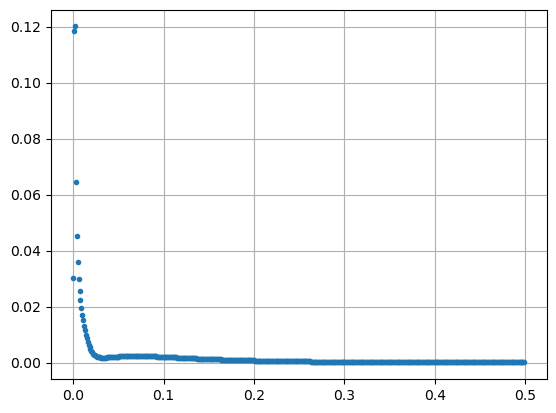

In [39]:
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.grid()
plt.plot(x, y, '.')
plt.show()

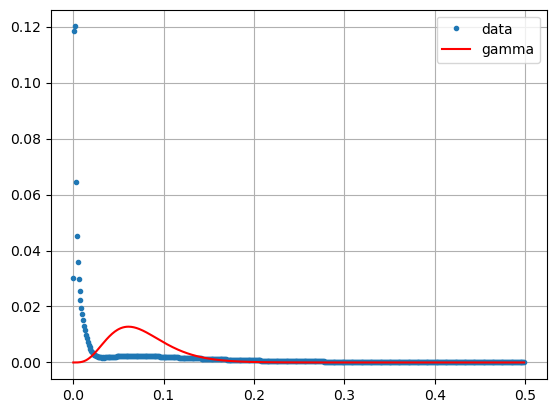

In [40]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r', label='gamma')
plt.legend()
plt.show()

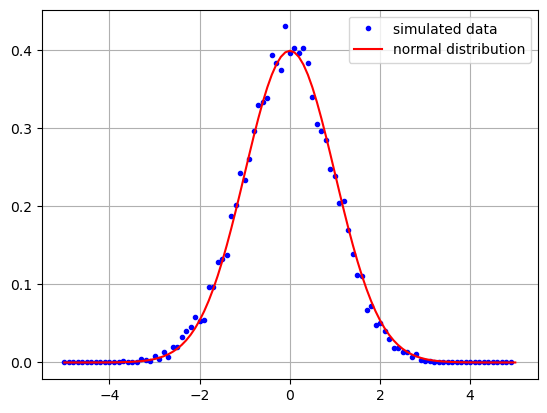

In [41]:
def X(n):
    return np.sum(np.cos(4*np.pi*(np.random.rand(n)-0.5)))/np.sqrt(n/2)

n= 10000
Xs = [X(n) for i in range(10000)]
y, x = np.histogram(Xs, 100, range=[-5,5])
plt.plot(x[:-1], y/1000, 'b.', label='simulated data')
plt.plot(x, norm.pdf(x), '-r', label='normal distribution')
plt.grid()
plt.legend()
plt.show()

## 2부
https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2

In [42]:
# Initialize the library.
ee.Initialize()

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [44]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [45]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [46]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))

In [47]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['08/05/20', '08/11/20', '08/17/20', '08/23/20', '08/29/20']

In [48]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

In [49]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)